# EDM Lyrics

In [185]:
# Imports
import requests
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import re
import plotly.express as px
import spacy
import random
from dotenv import load_dotenv
from collections import Counter
from collections import defaultdict
from PIL import Image
from wordcloud import WordCloud
from wordcloud import ImageColorGenerator
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from string import punctuation
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import ngrams
from spacy import displacy
from nltk.lm import MLE # language model
from nltk import word_tokenize, sent_tokenize
from nltk.util import pad_sequence, bigrams, ngrams, everygrams
from nltk.lm.preprocessing import pad_both_ends, flatten, padded_everygram_pipeline
from nltk.tokenize.treebank import TreebankWordDetokenizer

In [186]:
# Load .env environment variables
load_dotenv()



True

In [187]:
# Define function to use Shazam Core API, Electronic genre

def get_lyrics(querystring):

    url = "https://shazam-core.p.rapidapi.com/v1/tracks/details"

    headers = {
    'x-rapidapi-host': "shazam-core.p.rapidapi.com",
    'x-rapidapi-key': '8b0d2ef776msh6040e496268c238p105edajsn055150f280c7'
    }

    response = requests.request("GET", url, headers=headers, params=querystring)

    return response.json()

In [188]:
# Use 'Track details' endpoint to retrieve lyrics for a single track

genre = 'ELECTRONIC'
limit_songs = 50
country = 'US'

querystring = {"country_code":country,"genre_code":genre,"limit":limit_songs}
chart_response = get_chart_genre(querystring)

In [189]:
# Retrieve Track IDs

track_ids=[] # song identifier
titles = [] # song name
subtitles = [] # Main artist and featured artists

for track in range(len(chart_response)):
    track_ids.append(chart_response[track]['id'])
    titles.append(chart_response[track]['title'])
    subtitles.append(chart_response[track]['subtitle'])

print(f"The number of songs retrieved is : {len(track_ids)}")

chart_songs = pd.DataFrame({"Track Name": titles, "Artists": subtitles, 'TrackIDs': track_ids}).set_index('TrackIDs')
chart_songs.head(5)

The number of songs retrieved is : 50


,Track Name,Artists
TrackIDs,,
385133121,Love Tonight,Shouse
455370962,Lost In The Fire,Gesaffelstein & The Weeknd
577082976,Candy Shop,CryJaxx & Junior Charles
588664699,Lipstick,Kungs
140516014,After Dark,Mr.Kitty


In [190]:
# Data parsing

from collections import Counter

artists_list = list(chart_songs.Artists)
artist_counts = {artist: artists_list.count(artist) for artist in artists_list} #dict with frequency of artist in top chart

artists_df = pd.DataFrame(list(artist_counts.items()),columns = ['Artists','No. Songs in Top Chart']).set_index('Artists')
artists_df.sort_values(by = 'No. Songs in Top Chart', ascending=False, inplace=True) #sort values

In [191]:
# Visualize data

fig2 = px.bar(
    artists_df,
    color = "value",
    color_continuous_scale='earth',
    title = 'Top Artists on EDM Charts',
    height = 800
)
fig2.show()


In [192]:
# Retrieve Lyrics for all TrackIDs
track_ids 

lyrics=[]

for trackID in track_ids:
    querystring = {"track_id":trackID}
    track_details_response = get_lyrics(querystring)

    if track_details_response['sections'][1]['type'] != "LYRICS":  
        lyrics.append([''])
    else:
        track_lyrics = track_details_response['sections'][1]['text']
        lyrics.append(track_lyrics)

In [193]:
# Add lyrics column to dataframe with chart songs

all_lyrics = pd.Series(" ".join(map(str,song)) for song in lyrics) #each song is stored as a list, this turns each list into a string
all_lyrics_df = pd.DataFrame({"Lyrics": all_lyrics, "Track IDs": track_ids}).set_index('Track IDs')

lyrics_df = pd.concat([chart_songs, all_lyrics_df], axis=1)
lyrics_df.head(5)

,Track Name,Artists,Lyrics
385133121,Love Tonight,Shouse,"Oh Oh oh Oh-oh Oh, oh-oh When you're tired, w..."
455370962,Lost In The Fire,Gesaffelstein & The Weeknd,I wanna fuck you slow with the lights on (Ligh...
577082976,Candy Shop,CryJaxx & Junior Charles,"So seductive, let's go I'll take you to the c..."
588664699,Lipstick,Kungs,"Open the door, just take me down, I wanna step..."
140516014,After Dark,Mr.Kitty,"I see you, you see me How pleasant, this feeli..."


In [194]:
lyrics_df.drop(lyrics_df.loc[lyrics_df['Lyrics'] == ''].index.tolist(), inplace=True)
lyrics_df.head(50)

,Track Name,Artists,Lyrics
385133121,Love Tonight,Shouse,"Oh Oh oh Oh-oh Oh, oh-oh When you're tired, w..."
455370962,Lost In The Fire,Gesaffelstein & The Weeknd,I wanna fuck you slow with the lights on (Ligh...
577082976,Candy Shop,CryJaxx & Junior Charles,"So seductive, let's go I'll take you to the c..."
588664699,Lipstick,Kungs,"Open the door, just take me down, I wanna step..."
140516014,After Dark,Mr.Kitty,"I see you, you see me How pleasant, this feeli..."
568196935,Never Going Home,Kungs,Music (we can do it) We're only human (I can f...
582570870,Hurricane,Ofenbach & Ella Henderson,"Mm, hmm I want you to hold on, I want you to ..."
557351619,Marea (We’ve Lost Dancing),Fred again.. & The Blessed Madonna,We've lost dancing (lost dancing) This year we...
87244312,Midnight City,M83,Waiting in a car Waiting for a ride in the dar...
317723994,This Girl,Kungs & Cookin' On 3 Burners,Money rains from the sky above But keep the ch...


In [195]:
#Remove empty lyrics
new_lyrics_df = lyrics_df#.drop(
    #[
        #'50881429','10301916','98386465','589709697','519050306','328801000','541642606','54381216','316815447','357666338','342776723','275383992','239365741','577645246'
    #]
#)
new_lyrics_df

,Track Name,Artists,Lyrics
385133121,Love Tonight,Shouse,"Oh Oh oh Oh-oh Oh, oh-oh When you're tired, w..."
455370962,Lost In The Fire,Gesaffelstein & The Weeknd,I wanna fuck you slow with the lights on (Ligh...
577082976,Candy Shop,CryJaxx & Junior Charles,"So seductive, let's go I'll take you to the c..."
588664699,Lipstick,Kungs,"Open the door, just take me down, I wanna step..."
140516014,After Dark,Mr.Kitty,"I see you, you see me How pleasant, this feeli..."
568196935,Never Going Home,Kungs,Music (we can do it) We're only human (I can f...
582570870,Hurricane,Ofenbach & Ella Henderson,"Mm, hmm I want you to hold on, I want you to ..."
557351619,Marea (We’ve Lost Dancing),Fred again.. & The Blessed Madonna,We've lost dancing (lost dancing) This year we...
87244312,Midnight City,M83,Waiting in a car Waiting for a ride in the dar...
317723994,This Girl,Kungs & Cookin' On 3 Burners,Money rains from the sky above But keep the ch...


# Tokenizer
In this section, we use NLTK and Python to tokenize the text. This will include:

- Lowercase each word
- Remove Punctuation
- Remove Stopwords

In [196]:
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from string import punctuation
import re

In [197]:
# Instantiate the lemmatizer
lemmatizer = WordNetLemmatizer()

In [198]:
def tokenizer(Lyrics):
    """Tokenizes text."""
    # Create a list of the words
    words_tokened = word_tokenize(Lyrics)

    # Convert the words to lowercase
    words_lowered = [word.lower() for word in words_tokened]

    # Remove the punctuation
    regex = re.compile('[^a-zA-Z]')
    words_regexed = [regex.sub('', word) for word in words_lowered]
    
    # Remove the stop words
    sw = set(stopwords.words('english'))
    sw_add_ons = [ 'christmas', 'fuck', 'doo', '', 'ah', 'ca', 'na', 'Doo', 'doo', 'nt', 'ay', 'wan', 'wo', 'ta', 'oh', 'ohoh', 'cause', 'Romano', 'mistletoe', 'christmas', 'jingle', 'santa', 'dick', 'Hitmaka', 'fuckin', "fuckin'", 'fuck', 'shit', 'nigga', 'niggas', 'bitch', 'motherfucker', 'Motherfucker', 'dick']
    stopwords_removed = [word.lower() for word in words_regexed if word not in sw.union(sw_add_ons)]

    # Lemmatize Words into root words
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in stopwords_removed]

    return tokens

In [199]:
# Create a new tokens column for lyrics
lyrics_tokens = [tokenizer(words) for words in new_lyrics_df['Lyrics']]
new_lyrics_df['Tokens'] = lyrics_tokens
new_lyrics_df.head()

,Track Name,Artists,Lyrics,Tokens
385133121,Love Tonight,Shouse,"Oh Oh oh Oh-oh Oh, oh-oh When you're tired, w...","[tired, lonely, reach, arm, know, help, weathe..."
455370962,Lost In The Fire,Gesaffelstein & The Weeknd,I wanna fuck you slow with the lights on (Ligh...,"[slow, light, light, light, light, one, got, s..."
577082976,Candy Shop,CryJaxx & Junior Charles,"So seductive, let's go I'll take you to the c...","[seductive, let, go, take, candy, shop, let, l..."
588664699,Lipstick,Kungs,"Open the door, just take me down, I wanna step...","[open, door, take, step, dream, lift, ground, ..."
140516014,After Dark,Mr.Kitty,"I see you, you see me How pleasant, this feeli...","[see, see, pleasant, feeling, moment, hold, mi..."


In [200]:
# new_lyrics_df.reset_index(inplace=True)
new_lyrics_df

,Track Name,Artists,Lyrics,Tokens
385133121,Love Tonight,Shouse,"Oh Oh oh Oh-oh Oh, oh-oh When you're tired, w...","[tired, lonely, reach, arm, know, help, weathe..."
455370962,Lost In The Fire,Gesaffelstein & The Weeknd,I wanna fuck you slow with the lights on (Ligh...,"[slow, light, light, light, light, one, got, s..."
577082976,Candy Shop,CryJaxx & Junior Charles,"So seductive, let's go I'll take you to the c...","[seductive, let, go, take, candy, shop, let, l..."
588664699,Lipstick,Kungs,"Open the door, just take me down, I wanna step...","[open, door, take, step, dream, lift, ground, ..."
140516014,After Dark,Mr.Kitty,"I see you, you see me How pleasant, this feeli...","[see, see, pleasant, feeling, moment, hold, mi..."
568196935,Never Going Home,Kungs,Music (we can do it) We're only human (I can f...,"[music, human, feel, music, got, heated, yeah,..."
582570870,Hurricane,Ofenbach & Ella Henderson,"Mm, hmm I want you to hold on, I want you to ...","[mm, hmm, want, hold, want, stay, million, wor..."
557351619,Marea (We’ve Lost Dancing),Fred again.. & The Blessed Madonna,We've lost dancing (lost dancing) This year we...,"[lost, dancing, lost, dancing, year, lose, spa..."
87244312,Midnight City,M83,Waiting in a car Waiting for a ride in the dar...,"[waiting, car, waiting, ride, dark, night, cit..."
317723994,This Girl,Kungs & Cookin' On 3 Burners,Money rains from the sky above But keep the ch...,"[money, rain, sky, keep, change, got, enough, ..."


In [201]:
new_lyrics_df[['Lyrics', 'Tokens']]

,Lyrics,Tokens
385133121,"Oh Oh oh Oh-oh Oh, oh-oh When you're tired, w...","[tired, lonely, reach, arm, know, help, weathe..."
455370962,I wanna fuck you slow with the lights on (Ligh...,"[slow, light, light, light, light, one, got, s..."
577082976,"So seductive, let's go I'll take you to the c...","[seductive, let, go, take, candy, shop, let, l..."
588664699,"Open the door, just take me down, I wanna step...","[open, door, take, step, dream, lift, ground, ..."
140516014,"I see you, you see me How pleasant, this feeli...","[see, see, pleasant, feeling, moment, hold, mi..."
568196935,Music (we can do it) We're only human (I can f...,"[music, human, feel, music, got, heated, yeah,..."
582570870,"Mm, hmm I want you to hold on, I want you to ...","[mm, hmm, want, hold, want, stay, million, wor..."
557351619,We've lost dancing (lost dancing) This year we...,"[lost, dancing, lost, dancing, year, lose, spa..."
87244312,Waiting in a car Waiting for a ride in the dar...,"[waiting, car, waiting, ride, dark, night, cit..."
317723994,Money rains from the sky above But keep the ch...,"[money, rain, sky, keep, change, got, enough, ..."


# Sentiment Analysis Using Vader

In [202]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download("vader_lexicon")
analyzer = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Frank\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [203]:
# Sentiment calculation based on compound score
def get_sentiment(score):
    """
    Calculates the sentiment based on the compound score.
    """
    result = 0  # Neutral by default
    if score >= 0.05:  # Positive
        result = 1
    elif score <= -0.05:  # Negative
        result = -1

    return result

In [204]:
# Sentiment scores dictionaries
lyrics_sent = {
    "lyrics_compound": [],
    "lyrics_pos": [],
    "lyrics_neu": [],
    "lyrics_neg": [],
    "lyrics_sent": [],
}

# Get sentiment for the lyrics
for index, row in new_lyrics_df.iterrows():
    try:
        # Sentiment scoring with VADER
        lyrics_sentiment = analyzer.polarity_scores(row["Lyrics"])
        lyrics_sent["lyrics_compound"].append(lyrics_sentiment["compound"])
        lyrics_sent["lyrics_pos"].append(lyrics_sentiment["pos"])
        lyrics_sent["lyrics_neu"].append(lyrics_sentiment["neu"])
        lyrics_sent["lyrics_neg"].append(lyrics_sentiment["neg"])
        lyrics_sent["lyrics_sent"].append(get_sentiment(lyrics_sentiment["compound"]))

    except AttributeError:
        pass

# Attaching sentiment columns to the News DataFrame
lyrics_sentiment_df = pd.DataFrame(lyrics_sent)

# new_lyrics_df = new_lyrics_df.join(lyrics_sentiment_df)

# new_lyrics_df.head()
result_lyrics_df = pd.concat([new_lyrics_df, lyrics_sentiment_df], axis=1)
result_lyrics_df

,Track Name,Artists,Lyrics,Tokens,lyrics_compound,lyrics_pos,lyrics_neu,lyrics_neg,lyrics_sent
0,NaN,NaN,NaN,NaN,0.9991,0.319,0.665,0.016,1.0
1,NaN,NaN,NaN,NaN,0.9968,0.231,0.705,0.064,1.0
2,NaN,NaN,NaN,NaN,0.9664,0.087,0.884,0.029,1.0
3,NaN,NaN,NaN,NaN,0.9648,0.157,0.759,0.084,1.0
4,NaN,NaN,NaN,NaN,0.9949,0.175,0.764,0.061,1.0
...,...,...,...,...,...,...,...,...,...
588664699,Lipstick,Kungs,"Open the door, just take me down, I wanna step...","[open, door, take, step, dream, lift, ground, ...",NaN,NaN,NaN,NaN,NaN
589730835,Message In A Bottle (Colorblast Version),Colorblast,Sending out an SOS Sending out an SOS Sending ...,"[sending, so, sending, so, sending, so, sendin...",NaN,NaN,NaN,NaN,NaN
590490863,Measure of a Man,FKA twigs Feat. Central Cee,Nobody feels the pain behind the love you show...,"[nobody, feel, pain, behind, love, show, nobod...",NaN,NaN,NaN,NaN,NaN
87244312,Midnight City,M83,Waiting in a car Waiting for a ride in the dar...,"[waiting, car, waiting, ride, dark, night, cit...",NaN,NaN,NaN,NaN,NaN


### Analyzing Sentiments of Lyrics

In [205]:
# import plotly.express as px
# Plot overall sentiment scores for genre

positives = result_lyrics_df['lyrics_sent'].loc[result_lyrics_df['lyrics_sent'] == 1 ].count()
negatives = result_lyrics_df['lyrics_sent'].loc[result_lyrics_df['lyrics_sent'] == -1 ].count()
index_names = ['Positive', 'Negative']

lyrics_sentiment = pd.DataFrame([positives,negatives], columns = ['Count'])
lyrics_sentiment.index = index_names

EDM_sentiment = px.pie(
    lyrics_sentiment, 
    values = 'Count', 
    names=index_names, 
    hole = 0.4, 
    color_discrete_sequence=["green", "red"],
    width=1000, 
    height = 500,
    title='Overall Sentiment for EDM Song Lyrics'
    )  
EDM_sentiment

In [206]:
# Describe lyrics sentiment
result_lyrics_df.describe()

,lyrics_compound,lyrics_pos,lyrics_neu,lyrics_neg,lyrics_sent
count,36.000000,36.000000,36.000000,36.000000,36.000000
mean,0.392039,0.128361,0.779528,0.092139,0.444444
std,0.776651,0.097282,0.152198,0.112492,0.843274
min,-0.996900,0.000000,0.262000,0.000000,-1.000000
25%,0.000000,0.066000,0.726750,0.029750,0.000000
50%,0.849950,0.110000,0.782000,0.064000,1.000000
75%,0.985225,0.175250,0.878750,0.099500,1.000000
max,0.999200,0.445000,1.000000,0.536000,1.000000


# NLTK NGrams and Frequency Analysis


In [207]:
# Generate the Bitcoin N-grams where N=2
lyrics_text = ' '.join(new_lyrics_df["Lyrics"])
lyrics_processed = tokenizer(lyrics_text)
lyrics_ngrams = Counter(ngrams(lyrics_processed, n=2))
print(dict(lyrics_ngrams.most_common(80)))

{('run', 'run'): 49, ('let', 'go'): 46, ('lose', 'babe'): 29, ('need', 'love'): 28, ('love', 'tonight'): 25, ('babe', 'lose'): 25, ('keep', 'moving'): 24, ('lost', 'dancing'): 22, ('hold', 'hold'): 22, ('drive', 'night'): 21, ('tonight', 'need'): 20, ('go', 'let'): 17, ('dancing', 'lost'): 16, ('lost', 'lost'): 16, ('moving', 'keep'): 15, ('love', 'lololo'): 15, ('thinking', 'thinking'): 15, ('ohwoah', 'ohwoah'): 14, ('never', 'going'): 13, ('stop', 'shake'): 13, ('measure', 'man'): 12, ('hey', 'mama'): 12, ('blow', 'kiss'): 12, ('kiss', 'fire'): 12, ('fire', 'gun'): 12, ('gun', 'need'): 12, ('sending', 'so'): 12, ('world', 'hold'): 12, ('take', 'money'): 12, ('wasted', 'love'): 11, ('one', 'forever'): 10, ('take', 'hand'): 10, ('could', 'live'): 10, ('lean', 'blow'): 10, ('osonakoluna', 'osonakoluna'): 10, ('ani', 'kuni'): 10, ('kuni', 'chaouani'): 10, ('night', 'drive'): 10, ('lololo', 'love'): 10, ('every', 'time'): 10, ('til', 'morning'): 9, ('mind', 'like'): 9, ('like', 'hurricane

In [208]:
# Use the token_count function to generate the top 50 words from the lyrics
def token_count(Tokens, N=50):
    """Returns the top N tokens from the frequency count"""
    return Counter(Tokens).most_common(N)

In [209]:
# Use token_count to get the top 50 words from rnb lyrics
lyrics_top_50 = token_count(lyrics_processed)
lyrics_top_50

[('love', 80),
 ('run', 73),
 ('let', 72),
 ('need', 66),
 ('go', 60),
 ('feel', 52),
 ('hold', 52),
 ('got', 51),
 ('lost', 50),
 ('like', 48),
 ('time', 48),
 ('know', 47),
 ('keep', 45),
 ('take', 44),
 ('never', 43),
 ('dancing', 41),
 ('lose', 39),
 ('see', 36),
 ('girl', 35),
 ('tonight', 34),
 ('one', 34),
 ('kiss', 34),
 ('night', 33),
 ('babe', 32),
 ('stop', 31),
 ('fire', 30),
 ('heart', 30),
 ('want', 27),
 ('thinking', 27),
 ('yeah', 26),
 ('man', 26),
 ('baby', 25),
 ('come', 25),
 ('u', 24),
 ('ooh', 24),
 ('could', 24),
 ('ohwoah', 24),
 ('moving', 24),
 ('drive', 24),
 ('get', 22),
 ('world', 22),
 ('golden', 22),
 ('osonakoluna', 22),
 ('shake', 22),
 ('find', 19),
 ('mind', 19),
 ('alone', 18),
 ('make', 18),
 ('measure', 18),
 ('mama', 18)]

In [210]:
# Create df for most common tokens

lyrics_top50_df = pd.DataFrame(lyrics_top_50, columns=['Word', 'Count']).set_index('Word')
lyrics_top50_df

,Count
Word,
love,80
run,73
let,72
need,66
go,60
feel,52
hold,52
got,51
lost,50


In [211]:
# Export Top Words dataframe to CSV
lyrics_top50_df.to_csv('EDM_words.csv')

In [212]:
# Plot most common tokens
lyrics_top50_plot = px.bar(
    lyrics_top50_df,
    y = 'Count',
    color = "Count",
    color_continuous_scale='earth',
    title ='Top Words for EDM'
)
lyrics_top50_plot

# Word Clouds


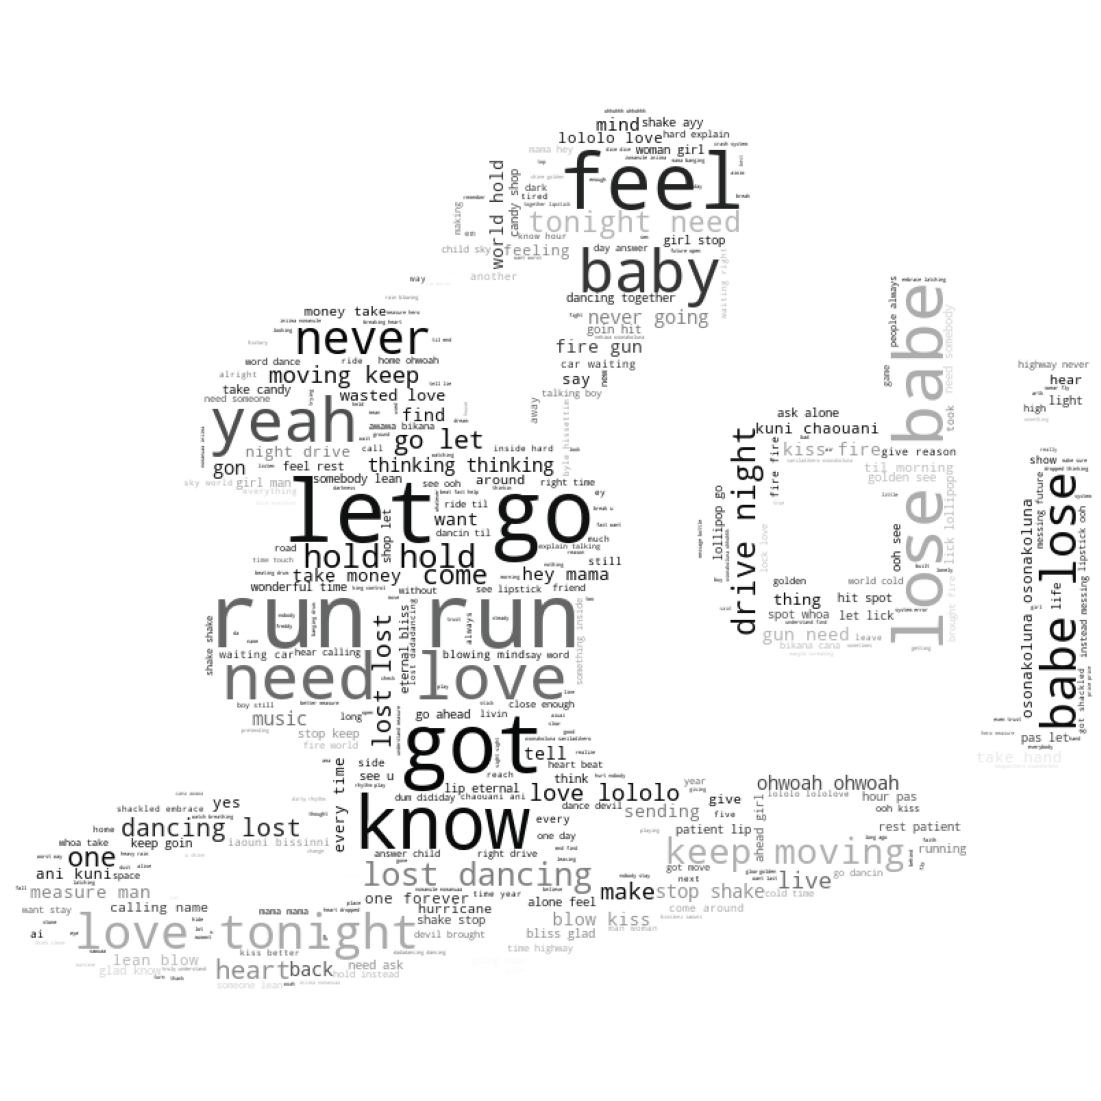

In [213]:
# Generate the RnB lyrics word cloud
lyrics_words_joined = ' '.join(lyrics_processed)

mask = np.array(Image.open("Images/dj3.png"))

wccc = WordCloud(background_color="white", max_words=2000, mask=mask, max_font_size=120, random_state=42, width=2000, height=1200, contour_color='black')

# generate word cloud
wccc.generate(lyrics_words_joined)

# create coloring from image
image_colors = ImageColorGenerator(mask)
plt.figure(figsize=(20,20))
plt.imshow(wccc.recolor(color_func=image_colors), interpolation="bilinear")

plt.axis("off")
plt.imshow(wccc)

# Save image as png
wccc.to_file("images/EDMwordcloud.png")


# NER - Spacy
In this section, we build a named entity recognition model for the hip hop lyrics, then visualize the tags using SpaCy.

In [214]:
# import spacy
# from spacy import displacy
# Load the spaCy model
nlp = spacy.load('en_core_web_sm')

In [215]:
# Run the NER processor on all of the text
edm_ner = nlp(lyrics_text)

# Add a title to the document
edm_ner.user_data['title'] = 'EDM NER'
displacy.render(edm_ner, style='ent')

In [216]:
# List all Entities

ent_labels=[]
entities=[]

for ent in rnb_ner.ents:
    ent_labels.append(ent.label_)
    entities.append(ent.text)

# Obtain frequency for each named entity

entities_freq = pd.DataFrame.from_dict([Counter(entities)]).T
entities_freq.columns = ['Frequency']
entities_freq.sort_values(by= 'Frequency', ascending=False, inplace = True)


# Retrieve labels for unique named entities

unique_nes = entities_freq.index.tolist()

labels = []

for word in unique_nes:
    idx = entities.index(word)
    label = ent_labels[idx]
    labels.append(label)

entities_freq['Label'] = labels

entities_freq

,Frequency,Label
tonight,32,TIME
all night,14,TIME
World,6,ORG
Osonakoluna,6,GPE
Awawa bikana,6,PERSON
...,...,...
Ani kuni,1,PERSON
Chaouani Ani,1,PERSON
Chaouani,1,PERSON
first,1,ORDINAL


In [217]:
# Bar chart of frequencies of Named Entities

entities_count = pd.DataFrame.from_dict([Counter(ent_labels)]).T
entities_count.columns = ['Count']

entities_count.sort_values('Count',inplace=True, ascending=False)

entities_count.reset_index(inplace=True)
entities_count = entities_count.rename(columns = {'index':'Named_Entity'})

entities_count.head()

,Named_Entity,Count
0,PERSON,66
1,TIME,52
2,GPE,38
3,ORG,23
4,CARDINAL,19


In [218]:
fig = px.bar(
    entities_count,
    x="Named_Entity",
    y="Count",
    color = "Count",
    color_continuous_scale='earth',
    title = "Top Named Entities found in EDM Songs"
     )
fig.show()

In [219]:
# Export Entities dataframe to CSV
entities_count.to_csv('EDM_entity_count.csv', index=False)

# Build a Markov Chain Function
We are going to build a simple Markov chain function that creates a dictionary:

- The keys should be all of the words in the corpus
- The values should be a list of the words that follow the keys

In [220]:
# from collections import defaultdict

def markov_chain(text):
    '''The input is a string of text and the output will be a dictionary with each word as
       a key and each value as the list of words that come after the key in the text.'''
    
    # Tokenize the text by word, though including punctuation
    words = text.split(' ')
#     for t in text:
#         words = t.split(' ')
#         print(words[0])
    
    # Initialize a default dictionary to hold all of the words and next words
    m_dict = defaultdict(list)
    
    # Create a zipped list of all of the word pairs and put them in word: list of next words format
    for current_word, next_word in zip(words[0:-1], words[1:]):
        m_dict[current_word].append(next_word)

    # Convert the default dict back into a dictionary
    m_dict = dict(m_dict)
    return m_dict

In [221]:
# Text generation function
def generate_sentence(chain, count=15):
    '''Input a dictionary in the format of key = current word, value = list of next words
       along with the number of words you would like to see in your generated sentence.'''

    # Capitalize the first word
    word1 = random.choice(list(chain.keys()))
    sentence = word1.capitalize()

    # Generate the second word from the value list. Set the new word as the first word. Repeat.
    for i in range(count-1):
        word2 = random.choice(chain[word1])
        word1 = word2
        sentence += ' ' + word2

    # End it with a period
    sentence += '.'
    return(sentence)

In [222]:
# Create the dictionary for lyrics, take a look at it
# lyrics_dict = new_lyrics_df['Lyrics_str'].apply(markov_chain)

lyrics_dict = markov_chain(lyrics_text)


In [223]:
lines = []
line = []

num_sentences=32

with open('markov_EDM.txt', 'w') as file:
    file.write('EDM Song by Markov Chains')
    file.write('\n')
    file.write('------------------------------------------')
    file.write('\n')

    for num in range(0,num_sentences):
        line = generate_sentence(lyrics_dict)
        lines.append(line)
        file.write(line)
        file.write('\n')

# Create a Text Generator
We're going to create a function that generates sentences. It will take two things as inputs:

- The dictionary you just created
- The number of words you want generated

In [224]:
# import random

def generate_sentence(chain, count=10):
    '''Input a dictionary in the format of key = current word, value = list of next words
       along with the number of words you would like to see in your generated sentence.'''

    # Capitalize the first word
    word1 = random.choice(list(chain.keys()))
    sentence = word1.capitalize()

    # Generate the second word from the value list. Set the new word as the first word. Repeat.
    for i in range(count-1):
        word2 = random.choice(chain[word1])
        word1 = word2
        sentence += ' ' + word2

    # End it with a period
    sentence += '.'
    return(sentence)

In [225]:
from nltk.lm import MLE # language model
from nltk import word_tokenize, sent_tokenize
from nltk.util import pad_sequence, bigrams, ngrams, everygrams
from nltk.lm.preprocessing import pad_both_ends, flatten, padded_everygram_pipeline
from nltk.tokenize.treebank import TreebankWordDetokenizer

In [226]:
# Tokenize lyrics corpus
lyrics_corpus = list(lyrics_df['Lyrics'].apply(word_tokenize))
n = 4
train_data, padded_sents = padded_everygram_pipeline(n, lyrics_corpus)
# Train and fit the model
EDM_model = MLE(n) # Lets train a 4-grams model
EDM_model.fit(train_data, padded_sents)

In [227]:
# Clean up the generated tokens to make it human-like.

detokenize = TreebankWordDetokenizer().detokenize

def generate_sent(model, num_words, random_seed):
    """
    :param model: An ngram language model from `nltk.lm.model`.
    :param num_words: Max no. of words to generate.
    :param random_seed: Seed value for random.
    """
    content = []
    for token in model.generate(num_words, random_seed=random_seed):
        if token == '<s>':
            continue
        if token == '</s>':
            break
        content.append(token)
    return detokenize(content)

In [228]:
# Predict text
mle_text = generate_sent(EDM_model, num_words=500, random_seed=10)
len(mle_text)  

# Note: pick a random seed that gives you 1000+ characters as the len(mle_text) 
# or run the generate_sent again until you hit your target size of lyrics

2123

In [229]:
with open('EDM_mle.txt', 'w', encoding="utf-8") as file:
    file.write(mle_text)

In [230]:
mle_text

"it Beating my drum like dum di-di-day I like the dirty rhythm you play I wannado is- And a- And take your money Pirate skulls and bones Sticks and stones and weed and bongs Running when we hit 'em Lethal poison for the system Pirate skulls and bones Sticks and stones and weed and bongs Running when we hit 'em Lethal poison for the system No one on the corner has swagger like us Hit me on my burner prepaid wireless We pack and deliver like UPS trucks Already going to hell, just pumping that gas No one on the corner has swagger like us Hit me on my burner prepaid wireless We pack and deliver like UPS trucks Already going to hell, just pumping that gas No one on the corner has swagger like us Hit me on my burner prepaid wireless We pack and deliver like UPS trucks Already going to hell, just pumping that gas All I wannakiss it I see a, ooh, I see a lipstick I wannado is- And a- And take your money All I wannastep into a dream Lift off the ground, once in the air, I'm floating up into the

In [231]:
mle_lyrics = [s for s in re.split("([A-H-J-Z][^A-H-J-Z]*)", mle_text) if s]
mle_lyrics

['it ',
 'Beating my drum like dum di',
 '-di',
 '-day I like the dirty rhythm you play I wannado is',
 '- ',
 'And a',
 '- ',
 'And take your money ',
 'Pirate skulls and bones ',
 'Sticks and stones and weed and bongs ',
 "Running when we hit 'em ",
 'Lethal poison for the system ',
 'Pirate skulls and bones ',
 'Sticks and stones and weed and bongs ',
 "Running when we hit 'em ",
 'Lethal poison for the system ',
 'No one on the corner has swagger like us ',
 'Hit me on my burner prepaid wireless ',
 'We pack and deliver like ',
 'U',
 'P',
 'S trucks ',
 'Already going to hell, just pumping that gas ',
 'No one on the corner has swagger like us ',
 'Hit me on my burner prepaid wireless ',
 'We pack and deliver like ',
 'U',
 'P',
 'S trucks ',
 'Already going to hell, just pumping that gas ',
 'No one on the corner has swagger like us ',
 'Hit me on my burner prepaid wireless ',
 'We pack and deliver like ',
 'U',
 'P',
 'S trucks ',
 'Already going to hell, just pumping that gas '

# Generate Audio from MLE Lyrics

In [236]:
from gtts import gTTS 
import os
speech = gTTS(text = mle_text, lang = 'en', slow = True)
speech.save("mle_lyrics_EDM.mp4")